In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import time
import datetime
import csv
import yaml
import configparser
import copy
import math 
import random
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib
# mpl.use('Agg')
%matplotlib inline
# %matplotlib notebook
from matplotlib import pyplot as plt 
from matplotlib.colors import ListedColormap

matplotlib.rcParams['lines.linewidth'] = 1
matplotlib.rcParams['lines.markersize'] = 5

# 1. Data Loading

In [4]:
ROOT_PATH = '../'
try: 
    os.chdir(ROOT_PATH)
    sys.path.insert(0, ROOT_PATH)
    print("Current working directory: {}".format(os.getcwd()))
except Exception:
    print("Directory: {} is not valid".format(ROOT_PATH))
    sys.exit(1)

Current working directory: /home/geshi/ABCDFusion


In [5]:
# load and parse config 
config_file = './configs.yaml'
with open(config_file, 'r') as infile:
    try:
        configs = yaml.safe_load(infile)
    except yaml.YAMLError as exc:
        sys.exit(exc)

In [6]:
auxiliary = configs['Auxiliary']
hyper_params = configs['HyperParams']

DATA_PATH = auxiliary['DATA_PATH']
DTI_DATA = auxiliary['DTI_DATA'] 
DIF_DATA = auxiliary['DIF_DATA'] 
COR_DATA = auxiliary['COR_DATA'] 
OUTCOME = auxiliary['OUTCOME']

test_size = hyper_params['valid_size']
num_splits = hyper_params['num_splits']
seed = hyper_params['seed']

In [7]:
df_data = pd.read_csv(os.path.join(DATA_PATH, DIF_DATA))
df_labels = pd.read_csv(os.path.join(DATA_PATH, OUTCOME))

In [8]:
df_data.head()

,src_subject_id,diffusivity_L_ anterior thalamic radiations_site,diffusivity_R_anterior thalamic radiations_site,diffusivity_corpus callosum_site,diffusivity_L_ cingulate cingulum_site,diffusivity_R_cingulate cingulum_site,diffusivity_L_ parahippocampal cingulum_site,diffusivity_R_parahippocampal cingulum_site,diffusivity_L_ corticospinal/pyramidal_site,diffusivity_R_corticospinal/pyramidal_site,...,diffusivity_L_ superior corticostriate_site,diffusivity_R_superior corticostriate_site,diffusivity_L_ striatal inferior frontal cortex_site,diffusivity_R_striatal inferior frontal cortex_site,diffusivity_L_ superior longitudinal fasiculus_site,diffusivity_R_superior longitudinal fasiculus_site,diffusivity_L_ temporal superior longitudinal fasiculus_site,diffusivity_R_temporal superior longitudinal fasiculus_site,diffusivity_L_ uncinate_site,diffusivity_R_uncinate_site
0,NDAR_INV2LXFHK41,0.500665,0.512323,0.466691,0.486522,0.482232,0.546345,0.535494,0.427484,0.430430,...,0.461575,0.457569,0.478427,0.494323,0.422518,0.424096,0.423639,0.428805,0.511813,0.518888
1,NDAR_INVA1PNCBDH,0.525174,0.527102,0.500287,0.534634,0.547726,0.605439,0.585200,0.459867,0.456394,...,0.494675,0.478835,0.534448,0.542871,0.477454,0.463502,0.479017,0.463377,0.589255,0.575754
2,NDAR_INV1VM14D0X,0.516808,0.516378,0.501181,0.526784,0.532297,0.601154,0.618355,0.463848,0.468607,...,0.495541,0.486898,0.538739,0.532617,0.476595,0.472333,0.474754,0.473699,0.575497,0.588667
3,NDAR_INVDPP9W7AV,0.524414,0.528752,0.536939,0.538915,0.534869,0.599012,0.583758,0.462256,0.461279,...,0.507670,0.501232,0.543031,0.548853,0.468871,0.467917,0.469638,0.478860,0.566899,0.566283
4,NDAR_INVP7YTV29E,0.524414,0.534527,0.511908,0.532493,0.550298,0.608295,0.601777,0.467033,0.465350,...,0.504204,0.495857,0.549896,0.547999,0.486894,0.477631,0.481574,0.477140,0.588395,0.596415


In [9]:
df_labels.head()

,src_subject_id,becomeCHR_3yr
0,NDAR_INV00CY2MDM,0
1,NDAR_INV00HEV6HB,0
2,NDAR_INV014RTM1V,0
3,NDAR_INV01AJ15N9,0
4,NDAR_INV01NAYMZH,0


In [10]:
X = df_data.iloc[:,1:].values
y = df_labels.iloc[:,1:].values
classes = [0, 1]

# 2. Machine Learning

## 2.1 Define Classifiers

In [11]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import RocCurveDisplay, roc_curve, PrecisionRecallDisplay, precision_recall_curve, ConfusionMatrixDisplay, confusion_matrix, auc
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

In [12]:
import umap

In [13]:
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

In [14]:
rng = np.random.RandomState(seed)

In [15]:
classifiers = [
    KNeighborsClassifier(5),
    SVC(kernel="linear", C=0.025, random_state=seed),
    SVC(gamma=2, C=1, random_state=seed),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=seed),
    DecisionTreeClassifier(max_depth=5, random_state=seed),
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=seed
    ),
    MLPClassifier(alpha=1, max_iter=1000, random_state=seed),
    AdaBoostClassifier(random_state=seed),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

## 2.2 Visualize Data Distribution and Do Simple Test

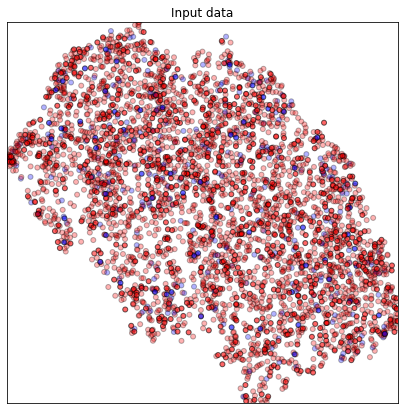

Train classifier Nearest Neighbors
| classes | precision | recall | fscore | support |
|    0    |  0.916  |  0.992  |  0.952  |   723   |
|    1    |  0.143  |  0.015  |  0.027  |    67   |
micro f1 score is 0.9089
confusion matrix is 
 [[717   6]
 [ 66   1]]
Train classifier Linear SVM


| classes | precision | recall | fscore | support |
|    0    |  0.915  |  1.000  |  0.956  |   723   |
|    1    |  0.000  |  0.000  |  0.000  |    67   |
micro f1 score is 0.9152
confusion matrix is 
 [[723   0]
 [ 67   0]]


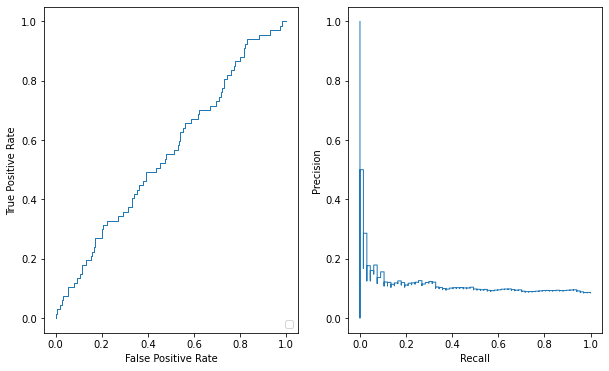

Train classifier RBF SVM


| classes | precision | recall | fscore | support |
|    0    |  0.915  |  1.000  |  0.956  |   723   |
|    1    |  0.000  |  0.000  |  0.000  |    67   |
micro f1 score is 0.9152
confusion matrix is 
 [[723   0]
 [ 67   0]]


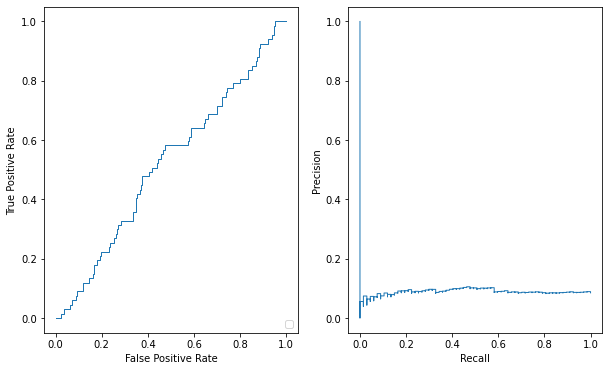

Train classifier Gaussian Process
| classes | precision | recall | fscore | support |
|    0    |  0.915  |  1.000  |  0.956  |   723   |
|    1    |  0.000  |  0.000  |  0.000  |    67   |
micro f1 score is 0.9152
confusion matrix is 
 [[723   0]
 [ 67   0]]
Train classifier Decision Tree
| classes | precision | recall | fscore | support |
|    0    |  0.915  |  0.997  |  0.954  |   723   |
|    1    |  0.000  |  0.000  |  0.000  |    67   |
micro f1 score is 0.9127
confusion matrix is 
 [[721   2]
 [ 67   0]]
Train classifier Random Forest
| classes | precision | recall | fscore | support |
|    0    |  0.915  |  1.000  |  0.956  |   723   |
|    1    |  0.000  |  0.000  |  0.000  |    67   |
micro f1 score is 0.9152
confusion matrix is 
 [[723   0]
 [ 67   0]]
Train classifier Neural Net
| classes | precision | recall | fscore | support |
|    0    |  0.915  |  1.000  |  0.956  |   723   |
|    1    |  0.000  |  0.000  |  0.000  |    67   |
micro f1 score is 0.9152
confusion matrix 

| classes | precision | recall | fscore | support |
|    0    |  0.915  |  0.997  |  0.954  |   723   |
|    1    |  0.000  |  0.000  |  0.000  |    67   |
micro f1 score is 0.9127
confusion matrix is 
 [[721   2]
 [ 67   0]]


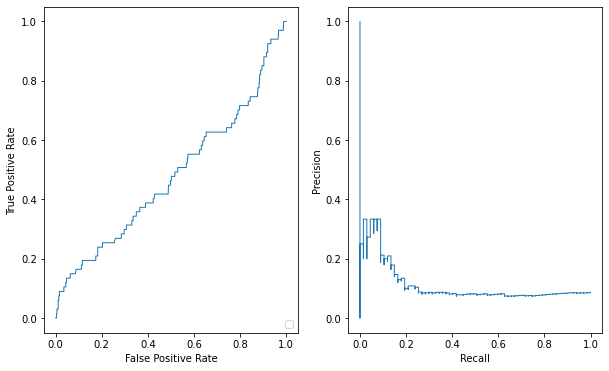

Train classifier Naive Bayes
| classes | precision | recall | fscore | support |
|    0    |  0.915  |  1.000  |  0.956  |   723   |
|    1    |  0.000  |  0.000  |  0.000  |    67   |
micro f1 score is 0.9152
confusion matrix is 
 [[723   0]
 [ 67   0]]
Train classifier QDA
| classes | precision | recall | fscore | support |
|    0    |  0.921  |  0.985  |  0.952  |   723   |
|    1    |  0.353  |  0.090  |  0.143  |    67   |
micro f1 score is 0.9089
confusion matrix is 
 [[712  11]
 [ 61   6]]


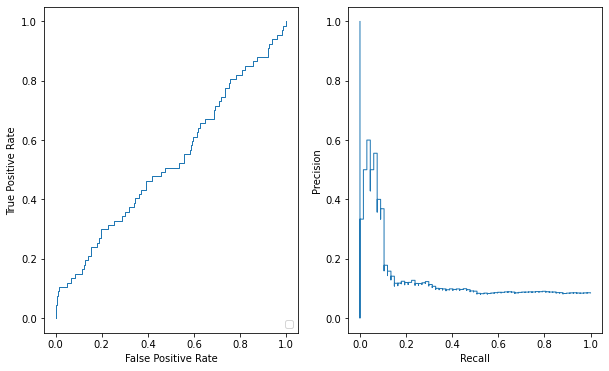

In [16]:
reducer = umap.UMAP()
X_embedding = reducer.fit_transform(X)

X_train, X_test, y_train, y_test, Xm_train, Xm_test = train_test_split(
    X, y, X_embedding, test_size=test_size, random_state=seed
)

x_min, x_max = X_embedding[:, 0].min(), X_embedding[:, 0].max()
y_min, y_max = X_embedding[:, 1].min(), X_embedding[:, 1].max()

reducer = umap.UMAP()
# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])

fig, ax = plt.subplots(figsize=(7, 7))
ax.set_title("Input data")    
# Plot the training points
ax.scatter(Xm_train[:, 0], Xm_train[:, 1], c=y_train, cmap=cm_bright, alpha=0.3, edgecolors="k")
# Plot the testing points
ax.scatter(
    Xm_test[:, 0], Xm_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())
plt.show()

# iterate over classifiers
for name, clf in zip(names, classifiers):
    
    print('Train classifier {}'.format(name))
    clf = make_pipeline(StandardScaler(), clf)
    # clf = make_pipeline(clf)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    # Calcute statistics
    precision, recall, fscore, support = score(y_test, y_pred)    

    print('| {:^6} | {:^6} | {:^6} | {:^6} | {:^6} |'.format('classes', 'precision', 'recall', 'fscore', 'support'))
    for cla, pre, rec, f1, sup in zip(classes, precision, recall, fscore, support):
        print('|  {:^6} |  {:^.3f}  |  {:^.3f}  |  {:^.3f}  |  {:^6} |'.format(cla, pre, rec, f1, sup))
        
    test_fscore = f1_score(y_test, y_pred, average='micro')
    print('micro f1 score is {:.4f}'.format(test_fscore))
    test_cfm = confusion_matrix(y_test, y_pred)
    print('confusion matrix is \n', test_cfm)
    
    # Display curves
    try:
        y_score = clf.decision_function(X_test)
        ## ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=clf.classes_[1])
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
        ## precision recall curve
        prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=clf.classes_[1])
        pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)
        ## visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
        roc_display.plot(ax=ax1)
        pr_display.plot(ax=ax2)
        plt.show()
    except:
        continue

## 2.2 Cross Validation

In [17]:
cv = StratifiedKFold(n_splits=num_splits)
# pick one from classifiers
classifier = classifiers[7]
clf = make_pipeline(StandardScaler(), classifier)
# classifier = svm.SVC(kernel="linear", probability=True, random_state=random_state)
# pick one from classifiers

         fpr       tpr     1-fpr      ass  thresholds
94  0.391123  0.434783  0.608877  0.52183   -0.049234
        fpr       tpr    1-fpr       ass  thresholds
55  0.23301  0.294118  0.76699  0.530554   -0.043665
         fpr  tpr     1-fpr      ass  thresholds
87  0.378641  0.5  0.621359  0.56068   -0.048887
          fpr  tpr     1-fpr       ass  thresholds
182  0.984743  1.0  0.015257  0.507628   -0.745736
         fpr       tpr    1-fpr       ass  thresholds
133  0.68516  0.779412  0.31484  0.547126   -0.064917


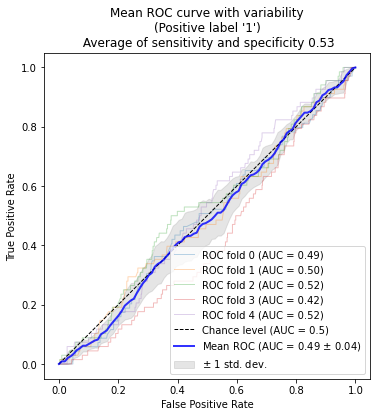

In [18]:
tprs = []
aucs = []
yis = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X, y)):
    clf.fit(X[train], y[train])
    
    y_score = clf.decision_function(X[test])
    fpr, tpr, thresholds =roc_curve(y[test], y_score, pos_label=clf.classes_[1])
    roc_auc = auc(fpr, tpr)
    
    i = np.arange(len(tpr))
    roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'ass' : pd.Series((tpr + (1-fpr))/2, index = i), 'thresholds' : pd.Series(thresholds, index = i)})
    yi = roc.iloc[(-roc['ass']).argsort()[:1]]
    print(yi)
    yis.append(yi['ass'].iloc[0])
    
    viz = RocCurveDisplay.from_estimator(
        clf,
        X[test],
        y[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == num_splits - 1),
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
mean_yi = np.mean(yis)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability\n(Positive label '{classes[1]}')\n Average of sensitivity and specificity {mean_yi:.2f}",
)
ax.axis("square")
ax.legend(loc="lower right")
plt.show()